In [1]:
import json
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

/Users/nickhoernle/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
question_types = {
    1: 'ranking',
    2: 'select5',
    3: 'pointwise_score'
}

json_data=open('../web-selection-form/data/questions.json').read()
question_mapping = json.loads(json_data)

In [3]:
# get the actual questions and answers
print(question_mapping['question1']['answers']['1'])
print(question_mapping['question1']['answers']['10'])

Current admission guidelines for US colleges admissions offices result in the colleges failing to admit many top quality students.
Beyond admissions, colleges should use Data Science as an early warning tool to detect students who need possible assistance.


In [17]:
columns = {
    'question1': dict([[i, np.nan] for i in (range(1,11)+['qustion_type'])]),
    'question2': dict([[i, np.nan] for i in (range(1,11)+['qustion_type'])]),
    'question3': dict([[i, np.nan] for i in (range(1,11)+['qustion_type'])]),
}

columns = ([('question1', i) for i in range(1,11)] 
            +[('question1', 'qustion_type'),('question1', 'end_time')]
            +[('question2', i) for i in range(1,11)]
            +[('question2', 'qustion_type'),('question2', 'end_time')]
            +[('question3', i) for i in range(1,11)]
            +[('question3', 'qustion_type'),('question3', 'end_time')]
            +[('feedback', '')]
            +[('start_time', '')]
            +[('end_time', '')])

columns = pd.MultiIndex.from_tuples(columns)

data_df = pd.DataFrame(columns=columns)
data_df.index.name = 'respondant'
data_df

Empty DataFrame
Columns: [(question1, 1), (question1, 2), (question1, 3), (question1, 4), (question1, 5), (question1, 6), (question1, 7), (question1, 8), (question1, 9), (question1, 10), (question1, qustion_type), (question1, end_time), (question2, 1), (question2, 2), (question2, 3), (question2, 4), (question2, 5), (question2, 6), (question2, 7), (question2, 8), (question2, 9), (question2, 10), (question2, qustion_type), (question2, end_time), (question3, 1), (question3, 2), (question3, 3), (question3, 4), (question3, 5), (question3, 6), (question3, 7), (question3, 8), (question3, 9), (question3, 10), (question3, qustion_type), (question3, end_time), (feedback, ), (start_time, ), (end_time, )]
Index: []

[0 rows x 39 columns]

In [33]:
data_path = './../responses/'
# Deal with question 1
    
for index, file in enumerate(os.listdir(data_path)):
    
    json_data=open(os.path.join(data_path, file)).read()
    data = json.loads(json_data)

    data_df.set_value(index=index, col=('feedback', ''), value=data['qualitative_feedback'])

    data_df.set_value(index=index, col=('start_time', ''), value=datetime.datetime.fromtimestamp(data['time_start']/1000.0))
    data_df.set_value(index=index, col=('end_time', ''), value=datetime.datetime.fromtimestamp(data['time_end']/1000.0))

    for question_number in range(1,4):

        question_number_string = 'question%i'%question_number
        question_type = 'question%i_type'%question_number
        question_time = 'question%i_time'%question_number
        question_selections = 'question%i_selections'%question_number

        data_df.set_value(index=index, col=(question_number_string, 'qustion_type'), value=data[question_type])
        data_df.set_value(index=index, col=(question_number_string, 'end_time'), value=datetime.datetime.fromtimestamp(data[question_time]/1000.0))

        if data[question_type] == 1: # 'ranking question'

            for i in range(1,11):

                answer = data[question_selections][i-1]
                data_df.set_value(index=index, col=(question_number_string, answer), value=i)

        elif data[question_type] == 2: # 'selecting question'

            for i in range(1,11):

                answer = 10 if i in data[question_selections] else 0
                data_df.set_value(index=index, col=(question_number_string, i), value=answer)

        else: # 'number question'

            answers = []
            for i in range(1,11):

                answers.append(int(data[question_selections][i]))
                
            for i in range(1,11):
                
                data_df.set_value(index=index, col=(question_number_string, i), value=(answers[i-1]/float(np.sum(answers))))

data_df = data_df.drop_duplicates()

In [35]:
data_df['question1'][data_df['question1']['qustion_type'] == 1]

,1,2,3,4,5,6,7,8,9,10,qustion_type,end_time
respondant,,,,,,,,,,,,
3,4,6,10,7,9,5,8,3,1,2,1,2017-04-27 14:50:13.334000
4,3,2,1,8,7,10,5,4,9,6,1,2017-04-27 15:10:08.808000
5,6,4,8,7,5,9,10,3,1,2,1,2017-04-27 15:54:31.656000
6,5,7,4,2,10,9,1,8,6,3,1,2017-04-27 17:54:57.872000
7,5,7,4,2,10,9,1,8,6,3,1,2017-04-27 17:54:57.872000
12,6,3,9,5,4,10,1,2,8,7,1,2017-04-27 20:48:54.949000
14,6,1,3,7,8,5,4,10,2,9,1,2017-04-27 23:49:01.170000
22,7,4,9,1,3,5,6,8,10,2,1,2017-04-28 09:31:33.617000
23,3,1,2,10,6,5,7,4,8,9,1,2017-04-28 09:47:31.472000


In [36]:
data_df

question1                                                         \
                    1          2          3          4          5          6   
respondant                                                                     
0           0.0555556  0.0925926  0.0925926   0.166667   0.037037  0.0740741   
1             0.15625    0.15625    0.15625   0.015625   0.015625   0.015625   
2                  10         10         10          0          0          0   
3                   4          6         10          7          9          5   
4                   3          2          1          8          7         10   
5                   6          4          8          7          5          9   
6                   5          7          4          2         10          9   
7                   5          7          4          2         10          9   
8            0.241379   0.103448  0.0344828   0.172414   0.103448  0.0344828   
9            0.132075   0.150943  0.0377358  0.0188679   0.113208   0.132075   
10           0.109091  0.0909091  0.0909091  0.0909091   0.109091  0.0909091   
11          0.0882353   0.205882   0.147059  0.0294118  0.0294118  0.0588235   
12                  6          3          9          5          4         10   
13           0.078125   0.109375    0.09375    0.09375      0.125     0.0625   
14                  6          1          3          7          8          5   
15                 10         10          0          0         10         10   
16                 10          0          0          0         10          0   
17                  0          0          0          0         10         10   
18                  0          0          0          0         10         10   
19           0.117647  0.0235294  0.0823529   0.117647  0.0941176   0.117647   
20           0.115385  0.0769231  0.0897436   0.102564   0.102564  0.0641026   
21              0.125   0.111111  0.0972222   0.111111  0.0694444  0.0972222   
22                  7          4          9          1          3          5   
23                  3          1          2         10          6          5   
24                 10         10         10          0          0          0   
25          0.0357143   0.160714      0.125      0.125  0.0892857  0.0357143   
26                 10         10         10          0          0          0   
27                  1          9          5          8          4          3   
28                  1          9          5          8          4          3   
29                  1          9          5          8          4          3   
30          0.0862069  0.0862069   0.137931  0.0172414   0.137931  0.0689655   
31                  7          3          5          6          8          4   
32           0.106383   0.212766   0.212766  0.0851064  0.0425532  0.0638298   
33                  2          4          5          6          7          8   

                                                        \
                    7          8          9         10   
respondant                                               
0            0.166667    0.12963   0.148148   0.037037   
1             0.15625    0.15625    0.15625   0.015625   
2                   0          0         10         10   
3                   8          3          1          2   
4                   5          4          9          6   
5                  10          3          1          2   
6                   1          8          6          3   
7                   1          8          6          3   
8           0.0344828   0.172414  0.0344828  0.0689655   
9            0.188679  0.0754717   0.132075  0.0188679   
10          0.0909091   0.145455  0.0909091  0.0909091   
11           0.147059  0.0294118   0.205882  0.0588235   
12                  1          2          8          7   
13           0.078125      0.125    0.09375   0.140625   
14                  4         10          2          9   
15     

Question 1


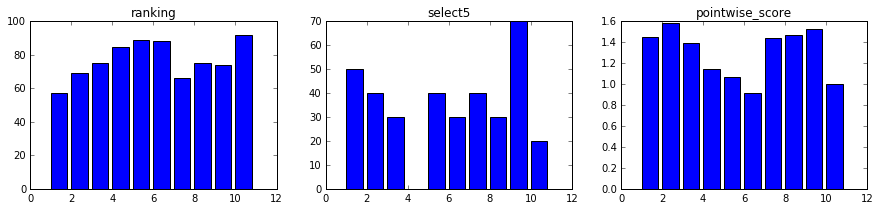

In [40]:
fig, axes = plt.subplots(1,3, figsize=(15,3))
print('Question 1')
for i, ax in enumerate(axes):
    
    agg_num = data_df['question1'][data_df['question1']['qustion_type'] == i + 1][[1,2,3,4,5,6,7,8,9,10]].sum()
    
    q_num = agg_num.index
    data = agg_num.values
    ax.bar(q_num, data)
    ax.set_title(question_types[i+1])

Question 2


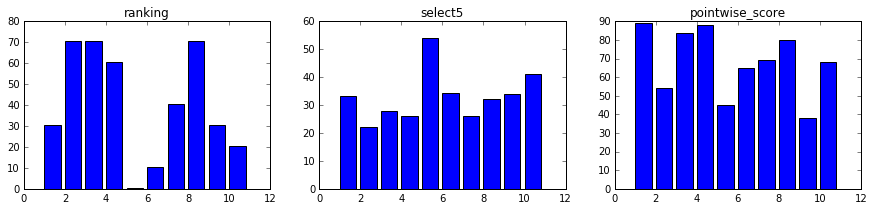

In [41]:
fig, axes = plt.subplots(1,3, figsize=(15,3))
print('Question 2')
for i, ax in enumerate(axes):
    
    agg_num = data_df['question2'][data_df['question1']['qustion_type'] == i + 1][[1,2,3,4,5,6,7,8,9,10]].sum()
    
    q_num = agg_num.index
    data = agg_num.values
    ax.bar(q_num, data)
    ax.set_title(question_types[i+1])

Question 3


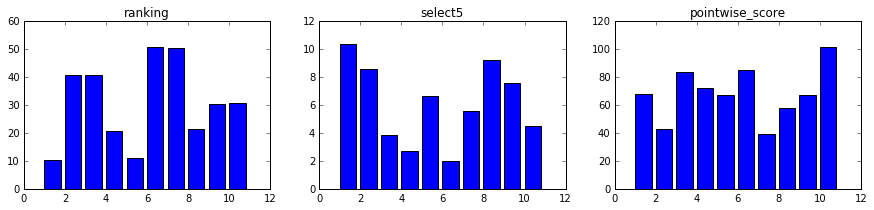

In [42]:
fig, axes = plt.subplots(1,3, figsize=(15,3))
print('Question 3')
for i, ax in enumerate(axes):
    
    agg_num = data_df['question3'][data_df['question1']['qustion_type'] == i + 1][[1,2,3,4,5,6,7,8,9,10]].sum()
    
    q_num = agg_num.index
    data = agg_num.values
    ax.bar(q_num, data)
    ax.set_title(question_types[i+1])

In [221]:
print(question_mapping['question1']['answers']['6'])
print(question_mapping['question1']['answers']['9'])
print(question_mapping['question1']['answers']['8'])
print
print(question_mapping['question2']['answers']['3'])
print(question_mapping['question2']['answers']['5'])
print(question_mapping['question2']['answers']['1'])
print
print(question_mapping['question3']['answers']['6'])
print(question_mapping['question3']['answers']['6'])
print(question_mapping['question3']['answers']['10'])

Improved admissions, resulting in improved graduation rates, will show in world rankings four years after initial implementation.
Currently colleges are not taking advantage of advanced statistical methods that can be used to predict student success.
Admissions officers should be more engaged in the long term goals of the university rather than optimizing for world rankings.

Unstructured, 'get-to-know' interviews are becoming popular in the workspace and in college admissions, yet these form a poor metric for predicting the future job performance of the interviewee.
Students are better at predicting other students' GPA scores when no interview is conducted.
Circumstance may be highly misleading in an interview scenario as an interviewee's demeanor may depend highly on external, hidden circumstances.

The American Journal of Psychiatry has published a study showing that the mental and social heath of the purported video game addicts is no different from individuals who are not addicted